In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf

def _expand_dim_image(t):
    for _ in range(2):
        t = tf.expand_dims(t, 0)
    
    return t

def _whitebalanced_image(image):
    _max = tf.reduce_max(image, axis=(0,1))
    _min = tf.reduce_min(image, axis=(0,1))
    _max, _min = map(_expand_dim_image, [_max, _min])
    image = tf.sub(image, _min)
    image = tf.div(image, tf.sub(_max, _min))
    return image

    

[     0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.  55620.   9231.   9102.   7771.
   7257.   6605.   6204.   5150.   4847.   5387.   5486.   5816.   5401.
   6095.   6623.   7798.   7879.  10535.  14135.  15071.  24128.  25302.
  30199.  28976.  30472.  28570.  33392.  35625.  29981.  33175.  25214.
  29148.  25981.  24669.  20766.  21408.  23813.  22768.  32373.  26199.
  22483.  10535.   6556.   7698.   4859.   5485.    372.      0.      0.
      0.]
[     0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0. 

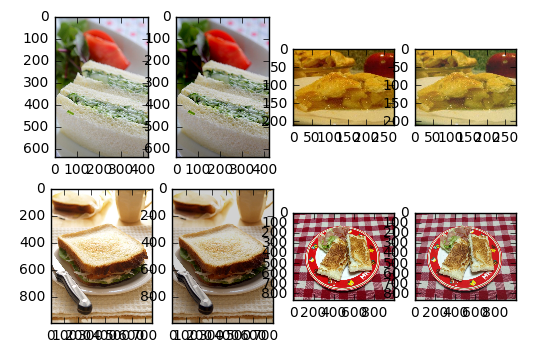

In [4]:

from PIL import Image # 画像表示用
import matplotlib.pyplot as plt # 画像表示用

files = tf.matching_files("./*.jpg")
q = tf.train.string_input_producer(files, shuffle=False)
reader = tf.WholeFileReader()
key, rdata = reader.read(q)
image = tf.image.decode_jpeg(rdata, channels=3)
image = tf.image.convert_image_dtype(image, tf.float32)
image2 = _whitebalanced_image(image)
image2 = tf.image.per_image_standardization(image2)
image2 = tf.div(image2, 4) # 2σまでの情報を保持
image2 = tf.add(image2, 0.5)
image2 = tf.clip_by_value(image2, 0.0, 1.0)
hist = tf.histogram_fixed_width(image2, [-1.0, 1.0], nbins=100, dtype=tf.float32)

N = 4

fig = plt.figure()

with tf.Session() as sess:
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    for i in range(N):
        img, img2, h= sess.run([image, image2, hist])
        fig.add_subplot(2,N,i*2+1)
        plt.imshow(img)
        fig.add_subplot(2,N,i*2+2)
        plt.imshow(img2)
        print(h)
    
    plt.show()
    coord.request_stop()
    coord.join(threads)

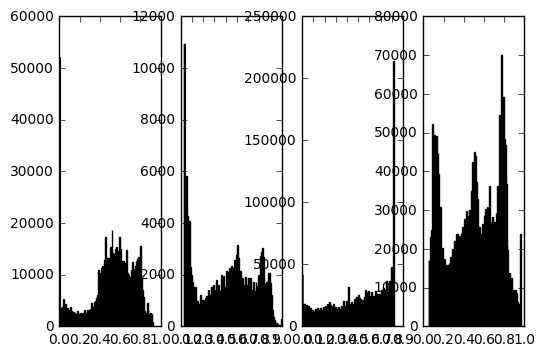

In [5]:
serialize_image = tf.reshape(image2, [-1])

fig = plt.figure()
with tf.Session() as sess:
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    for i in range(N):
        s = sess.run(serialize_image)
        ax = fig.add_subplot(1,N,i+1)
        ax.hist(s, bins=100)
    
    plt.show()
    coord.request_stop()
    coord.join(threads)

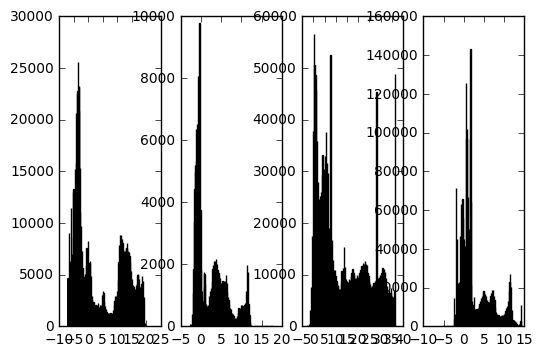

In [6]:
average = tf.reduce_mean(image, axis=(0,1))
serialized = tf.reshape(image, [-1,3])
serialized_wo_avg = tf.sub(serialized, average)
vcm = tf.matmul(tf.transpose(serialized_wo_avg), serialized_wo_avg)
l = tf.shape(serialized)[0]
vcm = tf.div(vcm, tf.to_float(l))
s, u, v = tf.svd(vcm)

diag = tf.diag(tf.div([1.0, 1.0, 1.0], tf.sqrt(s)))

z = tf.matmul(serialized, u)
w_wh = tf.matmul(diag, u)
y_wh = tf.matmul(serialized, w_wh)
image2 = tf.reshape(z, [tf.shape(image)[0], tf.shape(image)[1], 3])
image3 = tf.reshape(y_wh, [tf.shape(image)[0], tf.shape(image)[1], 3])

fig = plt.figure()
with tf.Session() as sess:
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    for i in range(N):
        s = sess.run(y_wh)
        ax = fig.add_subplot(1,N,i+1)
        ax.hist(s, bins=100)
#         img = sess.run(image3)
#         fig.add_subplot(1, N, i+1)
#         plt.imshow(img)
#         a = sess.run(z)
#         print(a)
    
    plt.show()
    coord.request_stop()
    coord.join(threads)

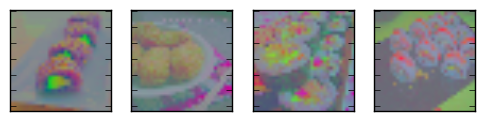

In [8]:
X = tf.reshape(image, [-1, 3])
N = tf.to_float(tf.shape(X)[0])
D = tf.to_float(tf.shape(X)[1])
xm = tf.reduce_mean(X, axis=[0])
X = tf.sub(X, xm)

C = tf.matmul(X, X, transpose_a=True) / N
lam, U, V = tf.svd(C)
eps = 0.000001
sqlam = tf.sqrt(tf.add(lam, eps))
Uzca = tf.matmul(U / sqlam, U, transpose_b=True)
Z = tf.matmul(X, Uzca, transpose_b=True)

absmax = tf.reduce_max(tf.abs(Z))
Z = (Z / absmax) * 0.5 + 0.5
image2 = tf.reshape(Z, [tf.shape(image)[0], tf.shape(image)[1], 3])

fig = plt.figure()
with tf.Session() as sess:
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    for i in range(4):
        img, uzca = sess.run([image2, Uzca])
        fig.add_subplot(1, 4, i+1)
        plt.tick_params(
            axis='both',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelbottom='off', # labels along the bottom edge are off
            labelleft='off') # labels along the bottom edge are off
        plt.imshow(img)
#         a = sess.run(z)
#         print(a)
    
    plt.show()
    coord.request_stop()
    coord.join(threads)

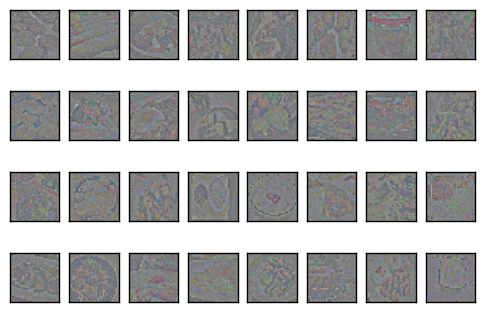

In [4]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
from PIL import Image # 画像表示用
import matplotlib.pyplot as plt # 画像表示用

BAT_SIZE=1024
IMG_SIZE=32

class ZcaWhitening:
    def __init__(self, eps=0.000000001):
        self._Z = None
        self.eps = eps

    def whiten(self, images):
        tf.unstack(tf.shape(images))
        N, _height, _width, _ = tf.unstack(tf.shape(images))
        X = tf.reshape(batch, [N, -1])
        xm = tf.reduce_mean(X, axis=[0])
        X = tf.sub(X, xm)

        if(self._Z is None):
            C = tf.matmul(X, X, transpose_a=True) / tf.to_float(N)
            lam, U, V = tf.svd(C)
            sqlam = tf.sqrt(tf.add(lam, self.eps))
            Uzca = tf.matmul(U / sqlam, U, transpose_b=True)
            self._Z = tf.matmul(X, Uzca, transpose_b=True)

        absmax = tf.reduce_max(tf.abs(self._Z))
        images = (self._Z / absmax) * 0.5 + 0.5
        return tf.reshape(images, [N, _height, _width, 3])

zca_whitening = ZcaWhitening(eps=0.0001)
        
files = tf.matching_files("./img/*.jpg")
q = tf.train.string_input_producer(files, shuffle=False)
reader = tf.WholeFileReader()

images = []

# for i in range(4):
key, rdata = reader.read(q)
image = tf.image.decode_jpeg(rdata, channels=3)
image = tf.image.convert_image_dtype(image, tf.float32)
image = tf.image.resize_images(image, (IMG_SIZE,IMG_SIZE))
#     images.append(image)
    
batch = tf.train.shuffle_batch([image], batch_size=BAT_SIZE, capacity=BAT_SIZE*3, min_after_dequeue=BAT_SIZE*2)

result = zca_whitening.whiten(batch)

fig = plt.figure()
with tf.Session() as sess:
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    img = sess.run(result)
#     print(img)
    l = min([BAT_SIZE, 32])
    for i in range(l):
        fig.add_subplot(4, 8, i+1)
        plt.tick_params(
            axis='both',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            left='off',      # ticks along the bottom edge are off
            right='off',         # ticks along the top edge are off
            labelbottom='off', # labels along the bottom edge are off
            labelleft='off') # labels along the bottom edge are off
        plt.imshow(img[i])
    
    plt.show()
    coord.request_stop()
    coord.join(threads)

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
from PIL import Image # 画像表示用
import matplotlib.pyplot as plt # 画像表示用

BAT_SIZE=32
IMG_SIZE=32

files = tf.matching_files("./img/*.jpg")
q = tf.train.string_input_producer(files, shuffle=False)
reader = tf.WholeFileReader()

images = []

# for i in range(4):
key, rdata = reader.read(q)
image = tf.image.decode_jpeg(rdata, channels=3)
image = tf.image.convert_image_dtype(image, tf.float32)
image = tf.image.resize_images(image, (IMG_SIZE,IMG_SIZE))
#     images.append(image)
    
batch = tf.train.batch([image], batch_size=BAT_SIZE)

X = tf.reshape(batch, [BAT_SIZE, -1])
N = tf.to_float(tf.shape(X)[0])
D = tf.to_float(tf.shape(X)[1])
xm = tf.reduce_mean(X, axis=[0])
X = tf.sub(X, xm)

C = tf.matmul(X, X, transpose_a=True) / N
lam, U, V = tf.svd(C)
eps = 0.0000001
sqlam = tf.sqrt(tf.add(lam, eps))
Uzca = tf.matmul(U / sqlam, U, transpose_b=True)

Z = tf.matmul(X, Uzca, transpose_b=True)

absmax = tf.reduce_max(tf.abs(Z))
Z = (Z / absmax) * 0.5 + 0.5
Z = tf.reshape(Z, [BAT_SIZE, IMG_SIZE, IMG_SIZE, 3])

fig = plt.figure()
with tf.Session() as sess:
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    img = sess.run(Z)
#     print(img)
    for i in range(BAT_SIZE):
        fig.add_subplot(4, 8, i+1)
        plt.tick_params(
            axis='both',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelbottom='off', # labels along the bottom edge are off
            labelleft='off') # labels along the bottom edge are off
        plt.imshow(img[i])
    
    plt.show()
    coord.request_stop()
    coord.join(threads)